In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url
from datasets import load_metric

seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device.upper()}" device.')

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 4
num_classes = 24
epochs = 20

Currently using "CUDA" device.


[Link to example tutorial](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb#scrollTo=MbNeV9xdw7rm)

In [2]:
images_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
color_masks_path = r'../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/'
masks_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

images = glob(images_path + '*.jpg')
colored_masks = glob(color_masks_path + '*.png')
masks = glob(masks_path + '*.png')

images = sorted([str(p) for p in images])
colored_masks = sorted([str(p) for p in colored_masks])
masks = sorted([str(p) for p in masks])

path_df = pd.DataFrame({'image': images, 'color_mask': colored_masks, 'mask': masks})
path_df.sample(2)

,image,color_mask,mask
209,../input/semantic-drone-dataset/dataset/semant...,../input/semantic-drone-dataset/RGB_color_imag...,../input/semantic-drone-dataset/dataset/semant...
280,../input/semantic-drone-dataset/dataset/semant...,../input/semantic-drone-dataset/RGB_color_imag...,../input/semantic-drone-dataset/dataset/semant...


In [3]:
labels = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
label_to_id = {v: k for k, v in enumerate(labels['name'].unique())}
id_to_label = {v: k for k, v in label_to_id.items()}

palette = []
for i in range(num_classes):
    color = labels.iloc[i, 1:].values.tolist()
    palette.append(color)

In [4]:
train, test = train_test_split(path_df, test_size=0.1, shuffle=True, random_state=42)
train, valid = train_test_split(train, test_size=0.15, shuffle=True, random_state=42)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 306, validation size: 54 and test size: 40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


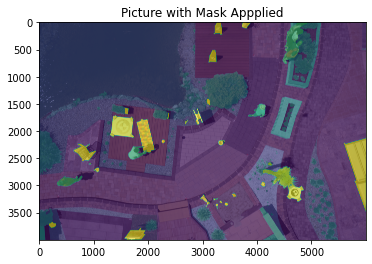

In [5]:
sample_img = path_df.sample(1, random_state=42)

image = Image.open(sample_img['image'].values[0])
cmask = Image.open(sample_img['color_mask'].values[0])
mask = Image.open(sample_img['mask'].values[0])

print('Image Size', np.asarray(image).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(image)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [6]:
class DroneDataset(Dataset):
    def __init__(self, dataframe, feature_extractor):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, ix):
        row = self.dataframe.loc[ix].squeeze()
        image = Image.open(row['image'])        
        mask = Image.open(row['mask'])
        
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")
        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()
        
        return encoded_inputs

In [7]:
feature_extractor = SegformerFeatureExtractor(reduce_labels=True) # remove background class

train_dataset = DroneDataset(train, feature_extractor)
valid_dataset = DroneDataset(valid, feature_extractor)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [9]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=num_classes, 
                                                         id2label=id_to_label, 
                                                         label2id=label_to_id,)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight

In [10]:
metric_train = load_metric("mean_iou")
metric_valid = load_metric("mean_iou")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
model.to(device)
print()

In [11]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()

In [12]:
train_losses = []
test_losses = []
val_iou = []; val_acc = []
train_iou = []; train_acc = []


for epoch in range(epochs):
    print("Epoch:", epoch+1)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_train.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 170 == 0:
            metrics = metric_train.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
            
    train_losses.append(loss.item())
    train_iou.append(metrics["mean_iou"])
    train_acc.append(metrics["mean_accuracy"])
            
    model.eval()
    print('-'*30, 'Validation', '-'*30)
    for idx, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_valid.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 19 == 0:
            metrics = metric_valid.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
    
    test_losses.append(loss.item())
    val_iou.append(metrics["mean_iou"])
    val_acc.append(metrics["mean_accuracy"])
    #try:
    #    evaluate_test()
    #except:
    #    pass

Epoch: 1


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 3.2377724647521973
Mean_iou: 0.008966196494167642
Mean accuracy: 0.06608967423657616
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 1.3885141611099243
Mean_iou: 0.21050177584766294
Mean accuracy: 0.2863005382952077
--------------------------------------------------
Epoch: 2


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.8230197429656982
Mean_iou: 0.10666930339151914
Mean accuracy: 0.17426540751402922
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.9710219502449036
Mean_iou: 0.14895289468930709
Mean accuracy: 0.2088102410108145
--------------------------------------------------
Epoch: 3


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.226168155670166
Mean_iou: 0.16869234323021887
Mean accuracy: 0.22972999531159052
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.8414705991744995
Mean_iou: 0.20420585556700147
Mean accuracy: 0.25907497239992916
--------------------------------------------------
Epoch: 4


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9079902768135071
Mean_iou: 0.21036518486586891
Mean accuracy: 0.2705767996792598
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.7395093441009521
Mean_iou: 0.23550377818994664
Mean accuracy: 0.2961189054495175
--------------------------------------------------
Epoch: 5


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.7603421211242676
Mean_iou: 0.24525965062902688
Mean accuracy: 0.3074025006527901
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.6382353901863098
Mean_iou: 0.2935548185234759
Mean accuracy: 0.35741067641398205
--------------------------------------------------
Epoch: 6


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.7814028859138489
Mean_iou: 0.2914806620346585
Mean accuracy: 0.3552281907552843
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.5622962713241577
Mean_iou: 0.34202536852196
Mean accuracy: 0.4064242010692252
--------------------------------------------------
Epoch: 7


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.7261178493499756
Mean_iou: 0.34732930421525277
Mean accuracy: 0.4124965339008009
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.5205973982810974
Mean_iou: 0.37763745407024873
Mean accuracy: 0.44570043182149743
--------------------------------------------------
Epoch: 8


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.6315823793411255
Mean_iou: 0.3813906590239417
Mean accuracy: 0.4509993223275659
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.4818533957004547
Mean_iou: 0.39123595486585394
Mean accuracy: 0.46472243307568967
--------------------------------------------------
Epoch: 9


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.573773205280304
Mean_iou: 0.3945065917503881
Mean accuracy: 0.46710175176182694
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.4596894383430481
Mean_iou: 0.39804345530239
Mean accuracy: 0.4742813224834318
--------------------------------------------------
Epoch: 10


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.4272473454475403
Mean_iou: 0.4128284230514497
Mean accuracy: 0.48762597049086626
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.4332175850868225
Mean_iou: 0.41095796010726926
Mean accuracy: 0.48899573260158696
--------------------------------------------------
Epoch: 11


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.5996103882789612
Mean_iou: 0.42959283193544234
Mean accuracy: 0.5045723866486135
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.418992817401886
Mean_iou: 0.42007127301663266
Mean accuracy: 0.49912994309565856
--------------------------------------------------
Epoch: 12


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.5532301068305969
Mean_iou: 0.4381793693859733
Mean accuracy: 0.5123039233434874
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.38972482085227966
Mean_iou: 0.4284823091071775
Mean accuracy: 0.5070767888286216
--------------------------------------------------
Epoch: 13


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.4881937503814697
Mean_iou: 0.45973550625594767
Mean accuracy: 0.5340037070545768
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3860825002193451
Mean_iou: 0.43598715301349356
Mean accuracy: 0.5200995746033116
--------------------------------------------------
Epoch: 14


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.4092371165752411
Mean_iou: 0.46619555124520784
Mean accuracy: 0.5403678949512233
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3723072409629822
Mean_iou: 0.44636345559013485
Mean accuracy: 0.5268787936549548
--------------------------------------------------
Epoch: 15


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.39658796787261963
Mean_iou: 0.4886354433147831
Mean accuracy: 0.5626996824967566
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3673439621925354
Mean_iou: 0.45630680139889535
Mean accuracy: 0.5331307586456894
--------------------------------------------------
Epoch: 16


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.5081408619880676
Mean_iou: 0.5036656520134281
Mean accuracy: 0.577157809213987
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.35251232981681824
Mean_iou: 0.470433755634552
Mean accuracy: 0.55311573975505
--------------------------------------------------
Epoch: 17


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.3866289258003235
Mean_iou: 0.5216468599276545
Mean accuracy: 0.5953974160214982
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.34166833758354187
Mean_iou: 0.4916425130723207
Mean accuracy: 0.5748258800991356
--------------------------------------------------
Epoch: 18


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.4491491913795471
Mean_iou: 0.5398092699295504
Mean accuracy: 0.6153248221390748
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3449375629425049
Mean_iou: 0.49813699467943096
Mean accuracy: 0.5775271254626357
--------------------------------------------------
Epoch: 19


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.28212419152259827
Mean_iou: 0.5684770410531363
Mean accuracy: 0.6448233893621557
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.32439714670181274
Mean_iou: 0.5040108762833044
Mean accuracy: 0.5816545977643482
--------------------------------------------------
Epoch: 20


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.37532100081443787
Mean_iou: 0.5768595988546793
Mean accuracy: 0.6524543480612309
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3359512388706207
Mean_iou: 0.5193160830398995
Mean accuracy: 0.6029223587910025
--------------------------------------------------


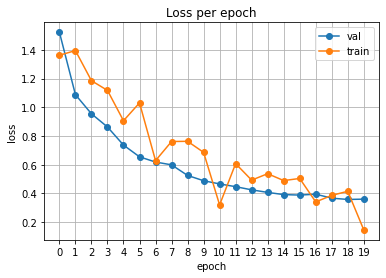

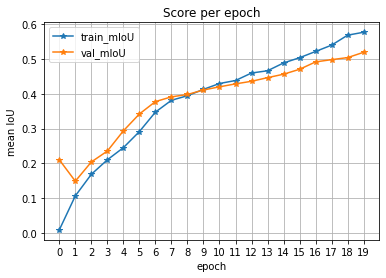

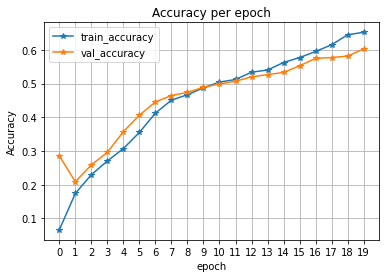

In [13]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc}

plot_loss(history)
plot_score(history)
plot_acc(history)

In [14]:
torch.save(model, 'SegFormer.pt')

# Evaluation

In [39]:
@torch.no_grad()
def evaluate_test(model=model, test=test):
    model.eval()
    idx = np.random.randint(len(test))
    image_p = test.loc[idx, 'image']
    gt_mask_p = test.loc[idx, 'mask']
    image = Image.open(image_p)
    gt_mask = Image.open(gt_mask_p)
    
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)
    
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits.cpu()
    upsampled_logits = nn.functional.interpolate(logits,
                                                 size=image.size[::-1],
                                                 mode='bilinear',
                                                 align_corners=False)
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    
    np_palette = np.array(palette)
    for label, color in enumerate(np_palette):
        color_seg[seg == label, :] = color
        
    color_seg = color_seg[..., ::-1]

    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)
    
    # GT
    gt_map = np.array(gt_mask)
    gt_map[gt_map == 0] = 255
    gt_map = gt_map - 1
    gt_map[gt_map == 254] = 255

    classes_map = np.unique(gt_map).tolist()
    unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]

    color_seg = np.zeros((gt_map.shape[0], gt_map.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(np_palette):
        color_seg[gt_map == label, :] = color

    color_seg = color_seg[..., ::-1]
    
    gt_mask = np.array(image) * 0.5 + color_seg * 0.5
    gt_mask = gt_mask.astype(np.uint8)

    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Predicted Image')
    plt.imshow(img)
    
    plt.subplot(132)
    plt.title('GT segmentation mask')
    plt.imshow(gt_mask)
    
    plt.subplot(133)
    plt.title('Original Image')
    plt.imshow(image)
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

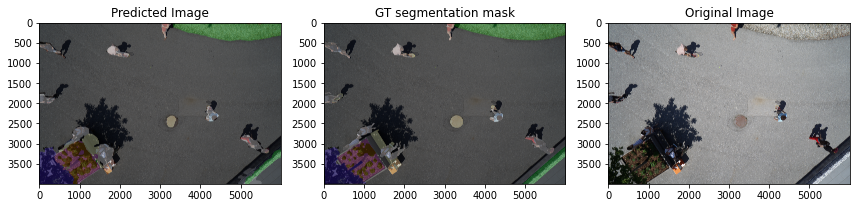

In [42]:
try:
    evaluate_test()
except:
    pass